In [17]:
import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt

from qiskit import Aer
from tqdm.notebook import tqdm
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import multiprocessing as mp

import sys
sys.path.insert(0, '../../src/')
from neuralnetwork import *
from analysis import *

#%matplotlib notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

np.set_printoptions(precision=4, suppress=None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
def parallel(args):
    model = args[0]
    x = args[1]
    y = args[2]
    verbose = args[3]
    
    model.train(x, y, verbose = verbose)
    
    return model

# Boston Housing Data

### Load Data

In [19]:
data = load_boston()
x = data.data

y = data.target.reshape(-1, 1)
y = scaler(y, a=0, b=1)

np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=100, test_size=100)

## PCA

In [20]:
#x_train_scaled = scaler(x_train, mode="standard")
pca = PCA(n_components=4)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

In [21]:
x_train_qcn = scaler(x_train_pca, mode="uniform", a=-np.pi/2, b=np.pi/2)
x_train_dnn = scaler(x_train_pca, mode="standard")

x_test_qcn = scaler(x_test_pca, mode="uniform", a=-np.pi/2, b=np.pi/2)
x_test_dnn = scaler(x_test_pca, mode="standard")

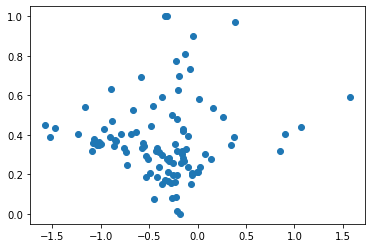

In [22]:
plt.plot(x_train_qcn[:,3], y_train,"o")

## DNN

  0%|          | 0/10 [00:00<?, ?it/s]

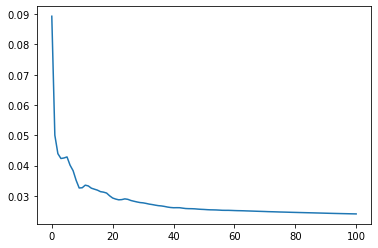

In [23]:
np.random.seed(42)

dnn_list = []
for i in tqdm(range(10)):
    dnn = sequential_dnn(dim = [4, 5, 1])
    dnn.train(x_train_dnn, y_train, epochs = 100)
    dnn_list.append(dnn)
    
saver(dnn_list, data_path("cancer_dnn_pca"))
plt.plot(dnn_list[0].loss)
plt.show()

In [24]:
print(dnn_list[0].loss[-1])

y_pred = dnn_list[0].predict(x_test_dnn)
loss = np.mean((y_pred - y_test)**2)
print(loss)

0.024074952603410416
0.03376278665749582


## QCN

In [25]:
np.random.seed(42)
qcn_list = []
for i in range(10):
    qcn = sequential_qnn(n_qubits = [4, 4],
                         dim = [4, 4, 1],
                         encoder= Encoder(),
                         ansatz = Ansatz(blocks = ["entangle", "ry"], reps=2),
                         sampler = Parity(),
                         cost = MSE(),
                         optimizer = Adam(lr=0.1),
                         shots=0)
    
    qcn_list.append([qcn, x_train_qcn, y_train, False])

qcn_list[0][3] = True    
    
with mp.Pool(10) as p:
    qcn_list = p.map(parallel, qcn_list)     
    
saver(qcn_list, data_path("boston_qcn"))

epoch: 0, loss: 0.057368539433307955
epoch: 1, loss: 0.03962613686114909
epoch: 2, loss: 0.03102650837400285
epoch: 3, loss: 0.03453093213486116
epoch: 4, loss: 0.03300046311718556
epoch: 5, loss: 0.029667497682462036
epoch: 6, loss: 0.029179484980538687
epoch: 7, loss: 0.02975365939643656
epoch: 8, loss: 0.02971644181077214
epoch: 9, loss: 0.02932572051129529
epoch: 10, loss: 0.028731105146330572
epoch: 11, loss: 0.027894786284279105
epoch: 12, loss: 0.027240572941465774
epoch: 13, loss: 0.027075553613743124
epoch: 14, loss: 0.026993869512484673
epoch: 15, loss: 0.02652681316189658
epoch: 16, loss: 0.025938915931547308
epoch: 17, loss: 0.025624569374243764
epoch: 18, loss: 0.025566779791647135
epoch: 19, loss: 0.025527032188358674
epoch: 20, loss: 0.02535448304713634
epoch: 21, loss: 0.025110027845084794
epoch: 22, loss: 0.024950685975199928
epoch: 23, loss: 0.024864997209932613
epoch: 24, loss: 0.02471560760322196
epoch: 25, loss: 0.024608090407100956
epoch: 26, loss: 0.0246756658148

In [35]:
qcn_list = loader(data_path("boston_qcn"))
qcn_list[4].loss[-1]

0.021287216506500273

In [30]:
qcn_list = loader(data_path("boston_qcn"))

y_pred = qcn_list[4].predict(x_test_qcn)
loss = np.mean((y_pred - y_test)**2)
print(loss)

0.02283515368581525
